<a href="https://colab.research.google.com/github/my-name-yash/micrograd-karpathy-walkthrough/blob/main/micrograd_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

# Build-Up

## Basics

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

In [ ]:
xs= np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
ys= f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

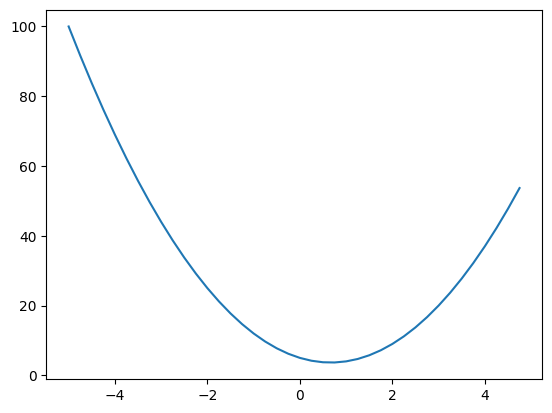

In [ ]:
plt.plot(xs,ys)
plt.show()

The following is the code to calculate a derivative using it defination

In [ ]:
x= 3.0
h=0.0000000001
f(x)

20.0

In [ ]:
f(x+h)

20.0000000014

In [ ]:
(f(x+h)-f(x))/h

14.000001158365194

In [ ]:
x= -3

In [ ]:
(f(x+h)-f(x))/h

-21.999966293151374

In [ ]:
x=2/3

In [ ]:
# slope is zero
(f(x+h)-f(x))/h

0.0

## LIL Complex

In [ ]:
a= 2.0
b= -3.0
c= 10.0
d= a*b + c
d

4.0

Finding derivative of d with respect to a, b, c

In [ ]:
h= 0.000001
d1_a= a*b+c
a+=h
d2_a= a*b+c
d2_a

3.9999969999999996

In [ ]:
(d2_a-d1_a)/h

-3.000000000419334

In [ ]:
h= 0.000001
d1_b= a*b+c
b+=h
d2_b= a*b+c
d2_b

3.999999000001

In [ ]:
(d2_b-d1_b)/h

2.0000010003684565

In [ ]:
h= 0.000001
d1_c= a*b+c
c+=h
d2_c= a*b+c
d2_c

4.000000000000999

In [ ]:
(d2_c-d1_c)/h

0.9999999992515995

# Value Object

Just a scalar wrapper to store a value, and its peripherals

---

"\_\_" surrounding a word represent the *dunder* or the *magic* method in python, these are overloaded strings that behave as predefined objects.

"_" before a word is a developer convention to let others know the variable is used for internal implementation.  

---

The `lambda` is defining a lambda function these are function with no required name, one expression and return some logic according to it.These are used to perform a specific operation, only once, not usually reused, just more concise form of function defination.

In [ ]:
class Value:

    def __init__(self,data,_children=(),_op='', label=''):
      self.data= data
      self.grad= 0
      self._backward= lambda: None
      self._prev= set(_children)
      self._op= _op
      self.label= label

    def __repr__(self):
      return f"Value(data={self.data})"

    def __add__(self, other):
      other= other if isinstance(other, Value) else Value(other) #allows a+1
      out= Value(self.data + other.data,(self,other),'+')

      def _backward():
        self.grad+= 1*out.grad
        other.grad+= 1*out.grad

      out._backward= _backward

      return out

    def __sub__(self,other):
      return self + (-other)

    def __mul__(self, other):
      other= other if isinstance(other, Value) else Value(other)
      out= Value(self.data * other.data,(self,other),'*')

      def _backward():
        self.grad+= other.data * out.grad
        other.grad+= self.data * out.grad

      out._backward= _backward

      return out

    def __pow__(self,other): # a^b
      assert isinstance(other,(int,float)),"only supporting int/float powers for now"
      out= Value(self.data**other,(self, ),f'**{other}')

      def _backward(): # b*a^(b-1)
        self.grad+= other * (self.data**(other-1)) * out.grad

      out._backward= _backward

      return out

    def tanh(self):
      x=self.data
      t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
      out= Value(t, (self, ), 'tanh')

      def _backward():
        self.grad+= (1-t**2)*out.grad

      out._backward= _backward

      return out

    def exp(self):
      x= self.data
      out= Value(math.exp(x), (self,), 'exp')

      def _backward():
        self.grad+= out.data * out.grad

      out._backward= _backward

      return out

    def __neg__(self):
      return self * -1

    def __rmul__(self,other): # allows other * self
      return self * other

    def __truediv__(self,other): # for self/other
      return self * other**-1

    def __radd__(self,other):#2+a
      return self+other


    def backward(self):
      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
            build_topo(child)
          topo.append(v)
      build_topo(self)
      self.grad= 1.0
      for node in reversed(topo):
        node._backward()

# Build-Up Returns

## Manual

$$
\tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1}
$$

In [ ]:
a= Value(2.0, label='a')
b= Value(-3.0,label='b')
c= Value(10.0,label='c')
a,b,c

(Value(data=2.0), Value(data=-3.0), Value(data=10.0))

In [ ]:
a+b

Value(data=-1.0)

In [ ]:
e=a*b
e.label='e'

In [ ]:
d=e+c

In [ ]:
d.label='d'

In [ ]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
d._op

'+'

In [ ]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad.%4f }" % (n.label, n.data, n.grad),
            shape='record'
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

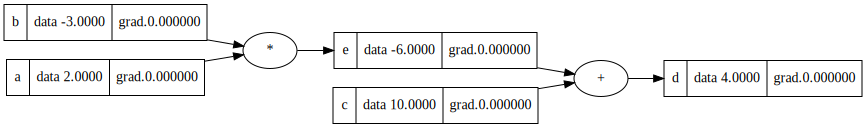

In [ ]:
draw_dot(d)

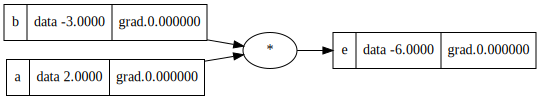

In [ ]:
draw_dot(e)

In [ ]:
f= Value(-2.0, label='f')

In [ ]:
L=d*f
L

Value(data=-8.0)

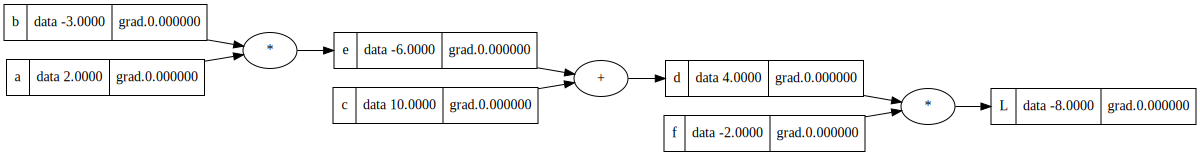

In [ ]:
L.label='L'
draw_dot(L)

In [ ]:
L.grad= 1.0
d.grad= -2.0
f.grad= 4.0

In [ ]:
def dif_check():
  h= 0.01

  a= Value(2.0, label='a')
  b= Value(-3.0,label='b')
  c= Value(10.0,label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f= Value(-2.0, label='f')
  L=d*f
  L1= L.data


  a= Value(2.0+h, label='a')
  b= Value(-3.0,label='b')
  c= Value(10.0,label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f= Value(-2.0, label='f')
  L=d*f
  L2= L.data

  print((L2-L1)/h)

dif_check()

5.999999999999872


dL/dc= (dL/dd)\*(dd/dc)  

dL/da= (dL/de)\*(de/da)
e= a*b

In [ ]:
c.grad= -2.0
e.grad= -2.0

In [ ]:
a.grad= -2.0*-3.0
b.grad= -2.0*2.0

Nudging the inputs in the direction of the gradient to increase L

In [ ]:
a.data+= -0.1*a.grad
b.data+= -0.1*b.grad
c.data+= -0.1*c.grad
f.data+= -0.1*f.grad

In [ ]:
e= a*b
d= e+c
L= d*f
L.data

-15.743999999999998

## Perceptron

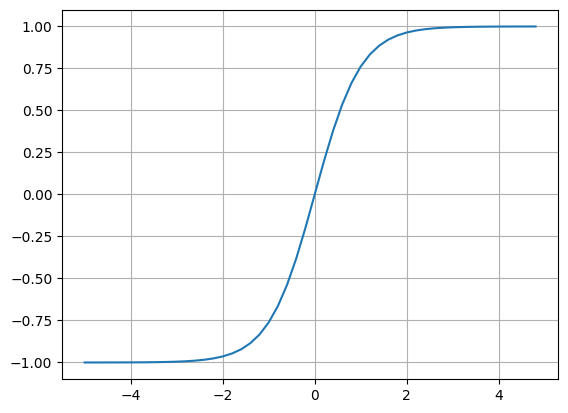

In [ ]:
# Activation Function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5,5,0.2)));
plt.grid()

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'

x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o= n.tanh();o.label='output'

In [ ]:
o.grad= 1

#do/dn= 1- o**2
1-o.data**2

n.grad= 0.5

#do/db= do/dn*dn/db
b.grad= 0.5
x1w1x2w2.grad= 0.5

#do/dx2w2=do/dx1w1x2w2*dx1w1x2w2/dx2w2
x1w1.grad= 0.5
x2w2.grad= 0.5

#do/dw1= do/dx1w1*dx1w1/dw1
#0.5*(x1)
#0.5*2
x1.grad= w1.data * x1w1.grad
w1.grad= x1.data * x1w1.grad
x2.grad= w2.data * x2w2.grad
w2.grad= x2.data * x2w2.grad

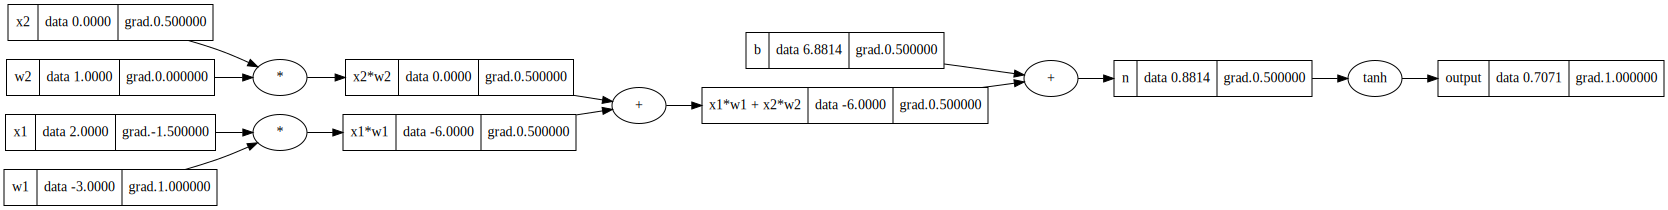

In [ ]:
draw_dot(o)

## Automating

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'

x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

O= n.tanh();O.label='output'

In [ ]:
#as base case
O.grad= 1

In [ ]:
O._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

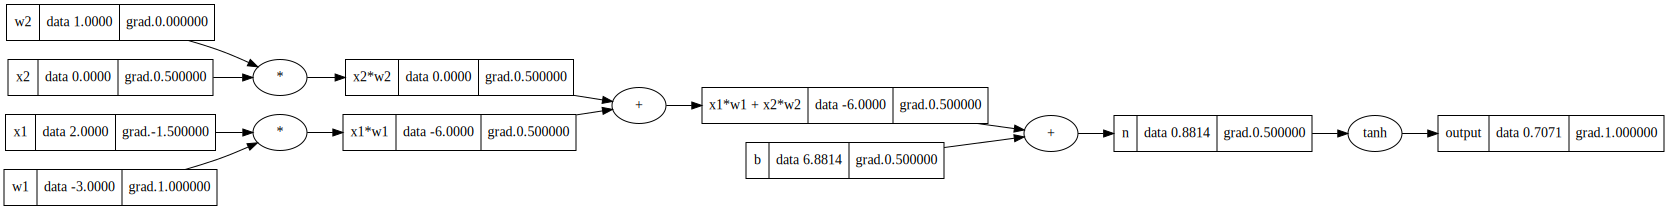

In [ ]:
draw_dot(O)


## Automated

The neural network is a Directed Acylic Graph (DAG). In it to automate the calling of backward() method on the nodes in an order of `childern->parents` we use the topological sort. On DAG this algo creates flow of edges from earlier nodes to the later ones.

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'

x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

Oo= n.tanh();O.label='output'

In [ ]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(Oo)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
for node in reversed(topo):
  node._backward()

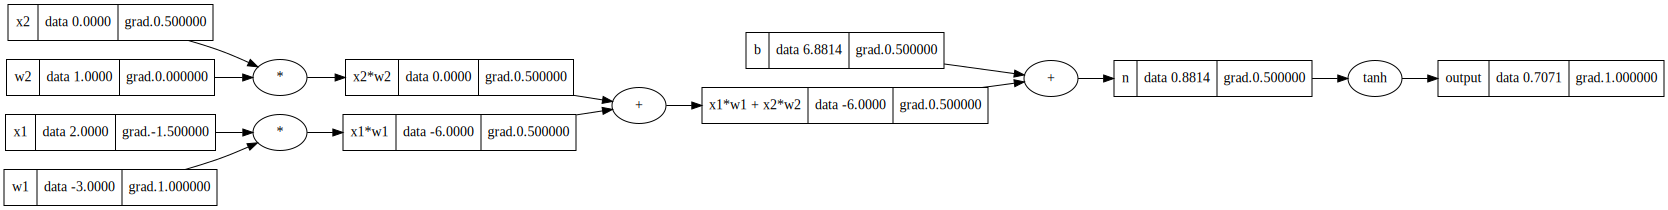

In [ ]:
draw_dot(o)

## Bug

In [ ]:
# a = Value(3.0, label='a')
# b = a + a   ; b.label = 'b'
# b.backward()
# draw_dot(b)
# #grad should be 2

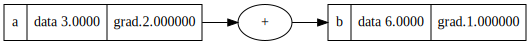

In [ ]:
#fixed version after making sure the grads add up, instead of being overwritten when the variable is used more than once
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)
#grad should be 2

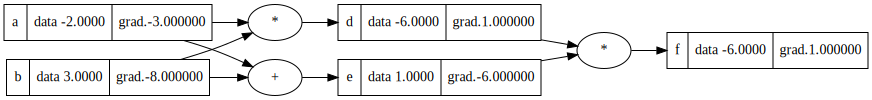

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

## Complxer

In [ ]:
a= Value(3.0)
b= Value(6.0)
c=b/a
b-a

Value(data=3.0)

In [ ]:
c

Value(data=2.0)

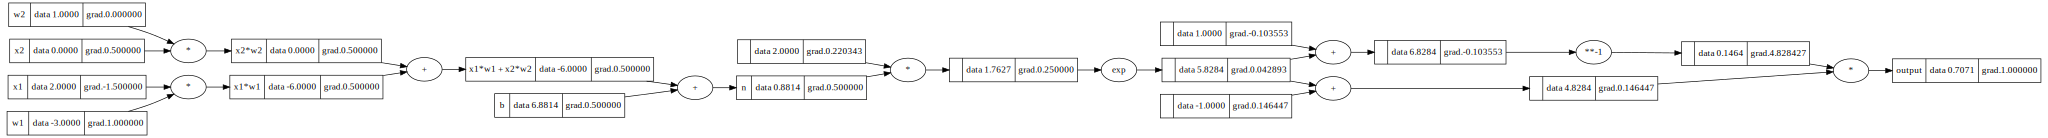

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'

x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
#----
e= (2*n).exp()
o= (e-1)/(e+1)
#----
o.label='output'
#-----
o.backward()
draw_dot(o)

## Via PyTorch

In [ ]:
import torch

x1 = torch.Tensor([2.0]).double()        ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()        ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()       ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()        ; w2.requires_grad = True
b  = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
torch.tensor([2.0]).double().dtype

torch.float64

In [ ]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [ ]:
o.item()

0.7071066904050358

In [ ]:
o.data.item()

0.7071066904050358

# Release

## Crazy Stuff

Building MLPs

---

`list(zip(self.w,x))` where x are inputs, prints `[(w1, x1), (w2, x2)]`  
Basically takes an input and its corresponding weight togather is is useful for summation operations

---
`Layer(2, 3)` creates a layer with three neurons.  
Each neuron takes the same 2 inputs, but each has its own weights and bias.  
The `2` specifies the number of inputs per neuron, and the `3` specifies the number of neurons in the layer.  
Each neuron produces a single output value.

---
A **Neuron** computes a weighted sum of inputs, adds a bias, and applies a nonlinearity.  

A **Layer** is a collection of neurons that all see the same input and produce multiple outputs.  

An **MLP** is a sequence of layers where the output of one layer becomes the input to the next.

In [ ]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weights
    self.b= Value(random.uniform(-1,1)) #bias

  def __call__(self,x):
    act= sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
    e= (2*act).exp()
    out= (e-1)/(e+1)
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
      return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
      return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x= [2.0, 3.0, -1.0]
n= MLP(3,[4,4,1])
n(x)

Value(data=0.6800613862452249)

In [ ]:
n.parameters()

[Value(data=0.3486090424206334),
 Value(data=0.4224631355195174),
 Value(data=-0.1044480061769788),
 Value(data=0.13164545109903703),
 Value(data=-0.8827941505776498),
 Value(data=-0.8623412982750629),
 Value(data=-0.1359240315909036),
 Value(data=-0.6847015289857388),
 Value(data=-0.7524354257149115),
 Value(data=0.11196738097605485),
 Value(data=-0.09939427351670527),
 Value(data=-0.5449173296274754),
 Value(data=0.956194483326418),
 Value(data=0.17903300629044927),
 Value(data=-0.7558123743018552),
 Value(data=-0.9820955077327214),
 Value(data=0.8926772255051143),
 Value(data=-0.2740067633078622),
 Value(data=-0.33207260325691457),
 Value(data=-0.8737127113854994),
 Value(data=-0.3175634962104368),
 Value(data=0.2706983292798546),
 Value(data=-0.53607276782186),
 Value(data=-0.4148190759813002),
 Value(data=0.8481269274860832),
 Value(data=-0.22256735735582445),
 Value(data=-0.38834172133650724),
 Value(data=0.07666953054860537),
 Value(data=-0.21377773038082792),
 Value(data=0.3019

In [ ]:
len(n.parameters())

41

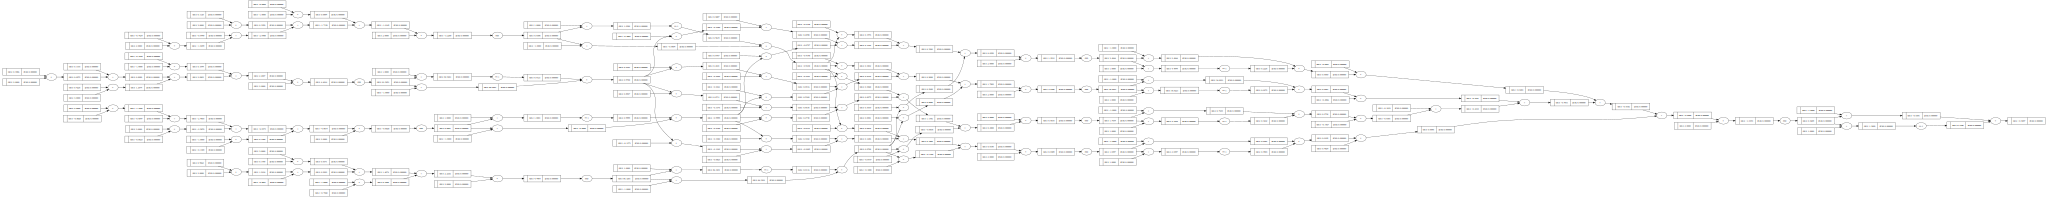

In [ ]:
draw_dot(n(x))

## Training

### Exploring Data

**41 parameters is exactly right** for this network 👍
Let’s count them.

Your model:

```python
n = MLP(3, [4, 4, 1])
```

That means:

* **Input size:** 3
* **Hidden layer 1:** 4 neurons
* **Hidden layer 2:** 4 neurons
* **Output layer:** 1 neuron

---

#### Parameter counting rule (golden rule)

Each neuron has:

* `nin` weights
* `+ 1` bias

So:

```
parameters per neuron = nin + 1
```

---

#### Layer-by-layer breakdown

##### 🔹 Layer 1: 3 → 4

Each neuron:

* 3 weights
* 1 bias
  = **4 params per neuron**

4 neurons:

```
4 × 4 = 16
```

---

##### 🔹 Layer 2: 4 → 4

Each neuron:

* 4 weights
* 1 bias
  = **5 params per neuron**

4 neurons:

```
4 × 5 = 20
```

---

##### 🔹 Layer 3 (output): 4 → 1

One neuron:

* 4 weights
* 1 bias
  = **5 params**

---

###### ✅ Total parameters

```
16 + 20 + 5 = 41
```

Yes — **exactly 41 trainable parameters**.

---

#### Important subtle point (you’re hinting at it)

You passed **4 input samples**:

```python
xs = [
  [2.0, 3.0, -1.0],
  ...
]
```

But:

> ❗ **Number of samples does NOT change number of parameters**

The same **41 parameters** are reused for **every forward pass**.

So what’s happening is:

* 4 forward passes
* through the **same network**
* accumulating into **one loss**
* producing **one gradient per parameter**

That’s why `draw_dot(loss)` looks insane 😄
It’s literally **4 copies of the network graph**, all tied to the same weights.

In [ ]:
xs=[ #inputs
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys= [1.0,-1.0,-1.0,1.0] #desired outputs

In [ ]:
y_pred= [n(x) for x in xs]
y_pred

[Value(data=-0.9373101584331408),
 Value(data=-0.5230547304610081),
 Value(data=-0.03700931554653617),
 Value(data=-0.8979789350054364)]

In [ ]:
losses= [(y_out-y_want)**2 for y_out, y_want in zip(y_pred, ys)]
losses

[Value(data=2.1598917358406937),
 Value(data=0.33913657511733103),
 Value(data=0.6988826873641246),
 Value(data=2.056566958168957)]

In [ ]:
#computing loss for each using MSE
loss= sum(losses)
loss

Value(data=5.254477956491106)

In [ ]:
loss.backward() #this gives each node its grad

In [ ]:
for i, layer in enumerate(n.layers):
    print(
        f"Layer {i}: "
        f"inputs = {len(layer.neurons[0].w)}, "
        f"neurons = {len(layer.neurons)}"
    )

Layer 0: inputs = 3, neurons = 4
Layer 1: inputs = 4, neurons = 4
Layer 2: inputs = 4, neurons = 1


In [ ]:
for li, layer in enumerate(n.layers):
    for ni, neuron in enumerate(layer.neurons):
        for wi, w in enumerate(neuron.w):
            print(f"L{li} N{ni} W{wi} grad = {w.grad}")
        print(f"L{li} N{ni} b grad = {neuron.b.grad}")


L0 N0 W0 grad = -0.20933592573015264
L0 N0 W1 grad = 0.18877839158992707
L0 N0 W2 grad = -0.412637510340191
L0 N0 b grad = -0.07902250090598549
L0 N1 W0 grad = 0.0025405144699597896
L0 N1 W1 grad = 0.013124972784821505
L0 N1 W2 grad = -0.009419949652692768
L0 N1 b grad = 0.008038396107630883
L0 N2 W0 grad = -0.009354612099590535
L0 N2 W1 grad = 0.021864099829901923
L0 N2 W2 grad = 0.12727676705010396
L0 N2 b grad = 0.04130297423604241
L0 N3 W0 grad = -0.06114859794684076
L0 N3 W1 grad = -0.144253396307041
L0 N3 W2 grad = -0.22068745844820412
L0 N3 b grad = -0.15024095460668846
L1 N0 W0 grad = 0.41994631593013954
L1 N0 W1 grad = -0.41982837880131
L1 N0 W2 grad = -0.35194028390461485
L1 N0 W3 grad = 0.4413151981397827
L1 N0 b grad = 0.42292669465738963
L1 N1 W0 grad = -0.11225341754452406
L1 N1 W1 grad = 0.29066665770596534
L1 N1 W2 grad = 0.20423680523296933
L1 N1 W3 grad = 0.4942784176923726
L1 N1 b grad = -0.30152323597058717
L1 N2 W0 grad = 0.08112161074835145
L1 N2 W1 grad = -0.0570

In [ ]:
for li, layer in enumerate(n.layers):
    for ni, neuron in enumerate(layer.neurons):
        print(f"L{li} N{ni} weights:", [w.data for w in neuron.w])
        print(f"L{li} N{ni} bias:", neuron.b.data)


L0 N0 weights: [0.3486090424206334, 0.4224631355195174, -0.1044480061769788]
L0 N0 bias: 0.13164545109903703
L0 N1 weights: [-0.8827941505776498, -0.8623412982750629, -0.1359240315909036]
L0 N1 bias: -0.6847015289857388
L0 N2 weights: [-0.7524354257149115, 0.11196738097605485, -0.09939427351670527]
L0 N2 bias: -0.5449173296274754
L0 N3 weights: [0.956194483326418, 0.17903300629044927, -0.7558123743018552]
L0 N3 bias: -0.9820955077327214
L1 N0 weights: [0.8926772255051143, -0.2740067633078622, -0.33207260325691457, -0.8737127113854994]
L1 N0 bias: -0.3175634962104368
L1 N1 weights: [0.2706983292798546, -0.53607276782186, -0.4148190759813002, 0.8481269274860832]
L1 N1 bias: -0.22256735735582445
L1 N2 weights: [-0.38834172133650724, 0.07666953054860537, -0.21377773038082792, 0.3019365353818775]
L1 N2 bias: 0.5887467648768474
L1 N3 weights: [-0.1272872046869784, -0.335001464153696, -0.07311296686652402, -0.1807569237286324]
L1 N3 bias: -0.08226737364837522
L2 N0 weights: [-0.14273026361769

In [ ]:
n.layers[0].neurons[0].w[0].grad

-0.20933592573015264

In [ ]:
n.layers[0].neurons[0].w[0].data

0.3486090424206334

In [ ]:
for p in n.parameters():
    print(p.data, p.grad)

0.3486090424206334 -0.20933592573015264
0.4224631355195174 0.18877839158992707
-0.1044480061769788 -0.412637510340191
0.13164545109903703 -0.07902250090598549
-0.8827941505776498 0.0025405144699597896
-0.8623412982750629 0.013124972784821505
-0.1359240315909036 -0.009419949652692768
-0.6847015289857388 0.008038396107630883
-0.7524354257149115 -0.009354612099590535
0.11196738097605485 0.021864099829901923
-0.09939427351670527 0.12727676705010396
-0.5449173296274754 0.04130297423604241
0.956194483326418 -0.06114859794684076
0.17903300629044927 -0.144253396307041
-0.7558123743018552 -0.22068745844820412
-0.9820955077327214 -0.15024095460668846
0.8926772255051143 0.41994631593013954
-0.2740067633078622 -0.41982837880131
-0.33207260325691457 -0.35194028390461485
-0.8737127113854994 0.4413151981397827
-0.3175634962104368 0.42292669465738963
0.2706983292798546 -0.11225341754452406
-0.53607276782186 0.29066665770596534
-0.4148190759813002 0.20423680523296933
0.8481269274860832 0.49427841769237

In [ ]:
len(n.parameters())

41

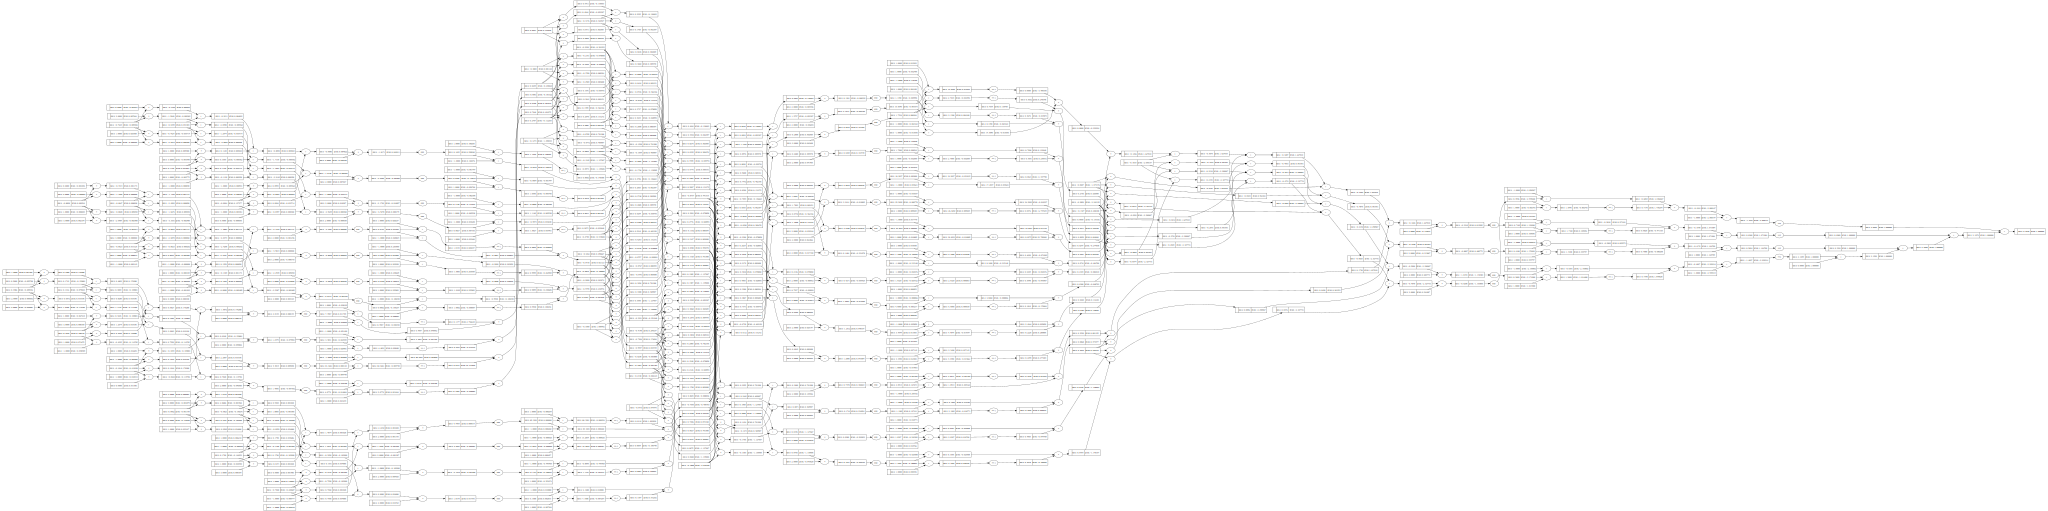

In [ ]:
draw_dot(loss)

### Trying Shize

In [ ]:
#now checking the loss
y_pred= [n(x) for x in xs]

losses= [(y_out-y_want)**2 for y_out, y_want in zip(y_pred, ys)]

#computing loss for each using MSE
loss= sum(losses)
loss

Value(data=4.976171919345836)

In [ ]:
#now checking the loss
y_pred= [n(x) for x in xs]

losses= [(y_out-y_want)**2 for y_out, y_want in zip(y_pred, ys)]

#computing loss for each using MSE
loss= sum(losses)
loss

Value(data=3.5622000251386314e-30)

In [ ]:
loss.backward()

In [ ]:
for p in n.parameters():
  p.data += -0.01 * p.grad #Moving in opposite direction of the gradient using Learning Rate

In [ ]:
n.layers[0].neurons[0].w[0].data

0.02795049839833119

In [ ]:
n.layers[0].neurons[0].w[0].grad

0.8837180078460952

In [ ]:
y_pred

[Value(data=1.0),
 Value(data=-1.0),
 Value(data=-0.9999999999999981),
 Value(data=1.0)]

### Loopin

In [ ]:
# for k in range(20):
#   #fwd pass
#   y_pred= [n(x) for x in xs]

#   losses= [(y_out-y_want)**2 for y_out, y_want in zip(y_pred, ys)]

#   #bwd pass
#   loss.backward()

#   #update
#   for p in n.parameters():
#     p.data += -0.05 * p.grad
#   print(k, loss.data)

0 3.5622000251386314e-30
1 3.5622000251386314e-30
2 3.5622000251386314e-30
3 3.5622000251386314e-30
4 3.5622000251386314e-30
5 3.5622000251386314e-30
6 3.5622000251386314e-30
7 3.5622000251386314e-30
8 3.5622000251386314e-30
9 3.5622000251386314e-30
10 3.5622000251386314e-30
11 3.5622000251386314e-30
12 3.5622000251386314e-30
13 3.5622000251386314e-30
14 3.5622000251386314e-30
15 3.5622000251386314e-30
16 3.5622000251386314e-30
17 3.5622000251386314e-30
18 3.5622000251386314e-30
19 3.5622000251386314e-30


**Karpathy's original list (from the tweet):**

1. Didn't try to overfit a single batch first — i.e., first check your model *can* fit a tiny dataset before debugging further.
2. Forgot to switch between `train()` and `eval()` mode (e.g., dropout/batchnorm).
3. Forgot to call `.zero_grad()` before `.backward()` in PyTorch.
4. Passed softmaxed outputs into a loss function that expects *raw logits* (e.g., `CrossEntropyLoss`).

**Additional ones from the same thread / extended unrolls:**

5. **Not disabling bias when using BatchNorm** — e.g., if your convolution or linear layer has a bias and *then* you batch-normalize, those biases are redundant and can introduce spurious parameters.
6. **Confusing `view()` with `permute()`** — reshaping tensors incorrectly because you think they are equivalent.

Those six cover what's in the original tweet plus the continuation that was part of the same thread.

---
**Why these matter (short context):**

* Mistake #1 is a classic debug baseline — if the network can’t fit a tiny dataset, something fundamental is broken.
* #2 and #3 are common PyTorch pitfalls where training behavior differs from evaluation because of dropout/batchnorm or gradient accumulation.
* #4 causes losses to saturate or gradients to vanish because the loss function expects raw scores.
* #5 is a subtle architectural thing: BatchNorm *already* has learnable shift parameters, so having a bias ahead of it is usually unnecessary.
* #6 leads to silent bugs in tensor shape manipulation, where operations produce incorrect orientation of axes.
---

***Here #3 error***

In [ ]:
for k in range(20):

    # 1. forward pass
    y_pred = [n(x) for x in xs]
    losses = [(y_out - y_want)**2 for y_out, y_want in zip(y_pred, ys)]
    loss = sum(losses)

    # 2. zero gradients
    for p in n.parameters():
        p.grad = 0.0

    # 3. backward pass
    loss.backward()

    # 4. update parameters
    for p in n.parameters():
        p.data -= 0.5 * p.grad

    print(k, loss.data)

0 0.0019527532057057163
1 0.0018991675197497357
2 0.001848276674770773
3 0.0017998875331912225
4 0.001753824743851856
5 0.00170992875510353
6 0.0016680540873567126
7 0.0016280678264945399
8 0.0015898483059705423
9 0.0015532839506537735
10 0.0015182722597845693
11 0.001484718909948887
12 0.0014525369619106548
13 0.0014216461575780519
14 0.0013919722954101005
15 0.0013634466742690685
16 0.0013360055971512247
17 0.0013095899274297366
18 0.0012841446912598795
19 0.0012596187206570756


In [ ]:
y_pred

[Value(data=0.9844432624088851),
 Value(data=-0.9913656273532664),
 Value(data=-0.977897957101126),
 Value(data=0.9786797292495629)]